# Imports

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import seaborn  as sns
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import OneCycleLR

# Global Methodology

We trained different models using two types of data:
- 1: without including news sentiment analysis
- 2: including news sentiment analysis

---> Maybe a bit dumb: the more you include data, the more your model is precise

---> Strongly depends of the quality of the datasets of the news and the quality of the prediction by the FinBERT model

## Structure of the data used

When we include sentiment data, we add three columns: positive, negative, neutral that describes to three different sentiments for the stock movement.

# Financial Time Series Forecasting using Sentiment Analysis with FinBERT and LSTM

## Loading datasets

In [3]:
# Load and preprocess `news`
news = pd.read_csv('data/bis_press_releases.csv')
news = news.dropna()
news['date'] = pd.to_datetime(news['date'], format='%d %b %Y')
news.sort_values(by='date', ascending=True, inplace=True)

In [4]:
news.head()

,date,url,title,content
7059,2017-01-13,https://www.bis.org/review/r170113b.htm,MarioVella: Productivity and stability for sus...,"Speech by Dr Mario Vella, Governor of the Cent..."
7058,2017-01-13,https://www.bis.org/review/r170113a.htm,UrjitR Patel: Macro and micro drivers of busin...,"Speech by Dr Urjit Urjit R Patel, Governor of ..."
7057,2017-01-16,https://www.bis.org/review/r170116a.htm,"JanetL Yellen: ""Welcoming remarks by Chair Yel...","Speech by Ms Janet L Yellen, Chair of the Boar..."
7056,2017-01-17,https://www.bis.org/review/r170117f.htm,WilliamC Dudley: Evolving consumer behavior,"Remarks by Mr William C Dudley, President and ..."
7055,2017-01-17,https://www.bis.org/review/r170117e.htm,Muhammadbin Ibrahim: Central bank collaboratio...,"Remarks by Mr Muhammad bin Ibrahim, Governor o..."


In [105]:
# Load and preprocess `prices`
prices = pd.read_csv('data/sp500_prices.csv')
prices['date'] = pd.to_datetime(prices['Date'])
prices = prices.drop(columns=['Date'])
prices.sort_values(by='date', ascending=True, inplace=True)

In [102]:
prices.head()

,Open,High,Low,Close,Volume,Company,date
0,149.523407,150.501678,148.177261,148.871231,3001123,3M,2017-01-03
326,54.250000,54.849998,53.230000,53.590000,1239500,Molina Healthcare,2017-01-03
325,185.000000,189.169998,184.809998,189.050003,378600,Huntington Ingalls Industries,2017-01-03
324,58.099998,58.910000,57.750000,58.320000,3004100,T-Mobile US,2017-01-03
323,10.630000,10.630000,10.630000,10.630000,0,Amcor,2017-01-03


## News Data Sentiment Analysis

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
class_labels = model.config.id2label
prob_labels = model.config.label2id

text1 = news['content'].values[0]
inputs = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)

# Perform inference
with torch.no_grad():  # No gradient calculation needed for predictions
    outputs = model(**inputs)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs, dim=-1).item()

# Print the results
print("Predicted class:", class_labels[predicted_class])
print("Probabilities:", probs)
print('labels assignation:', prob_labels)

/Users/remibreton/miniconda3/envs/my_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predicted class: neutral
Probabilities: tensor([[0.0554, 0.0202, 0.9244]])
labels assignation: {'positive': 0, 'negative': 1, 'neutral': 2}


In [8]:
def sentiment_labelling(df):
    """
    Perform sentiment labelling on the given DataFrame.
    Adds 'negative', 'neutral', and 'positive' columns to the DataFrame.
    Processes the DataFrame to group by date and fill missing values.
    """
    # Initialize sentiment columns
    df['negative'] = 0.0
    df['neutral'] = 0.0
    df['positive'] = 0.0

    # Initialize the tqdm progress bar
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Sentiment Analysis", dynamic_ncols=True):
        text = row['content']

        # Tokenize the text
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)

        # Get predicted probabilities (softmax output)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).squeeze().tolist()

        # Assign probabilities to the corresponding columns
        df.at[index, 'positive'] = probs[0]
        df.at[index, 'negative'] = probs[1]
        df.at[index, 'neutral'] = probs[2]

    # Drop unnecessary columns
    if {'url', 'title', 'content'}.issubset(df.columns):
        df = df.drop(columns=['url', 'title', 'content'])

    # Group by date and calculate mean sentiment scores
    df = df.groupby("date").mean().reset_index()

    # Ensure the 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Create a full date range
    date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())

    # Reindex to include all dates and forward-fill missing values
    df = df.set_index("date").reindex(date_range)
    df = df.ffill().reset_index()
    df.rename(columns={"index": "date"}, inplace=True)

    # Sort by date in descending order
    df = df.sort_values(by="date", ascending=True).reset_index(drop=True)

    return df

In [9]:
news = sentiment_labelling(news)

Processing Sentiment Analysis: 100%|██████████| 7057/7057 [16:35<00:00,  7.09it/s]


# Feeding Single Company + sentiment as inputs

In [10]:
news.head()

,date,negative,neutral,positive
0,2017-01-13,0.014504,0.804525,0.180970
1,2017-01-14,0.014504,0.804525,0.180970
2,2017-01-15,0.014504,0.804525,0.180970
3,2017-01-16,0.018809,0.858669,0.122522
4,2017-01-17,0.241673,0.516510,0.241817


In [104]:
prices.head(100)

,Open,High,Low,Close,Volume,Company,date
0,149.523407,150.501678,148.177261,148.871231,3001123,3M,2017-01-03
326,54.250000,54.849998,53.230000,53.590000,1239500,Molina Healthcare,2017-01-03
325,185.000000,189.169998,184.809998,189.050003,378600,Huntington Ingalls Industries,2017-01-03
324,58.099998,58.910000,57.750000,58.320000,3004100,T-Mobile US,2017-01-03
323,10.630000,10.630000,10.630000,10.630000,0,Amcor,2017-01-03
...,...,...,...,...,...,...,...
292,135.899994,138.660004,135.179993,138.539993,1329200,Rockwell Automation,2017-01-03
291,142.389999,143.830002,142.229996,143.669998,1966400,Thermo Fisher Scientific,2017-01-03
290,11.220000,11.650000,11.070000,11.640000,1088300,Builders FirstSource,2017-01-03
289,30.230000,30.549999,30.110001,30.360001,2650200,Weyerhaeuser,2017-01-03


In [12]:
prices['high ret'] = prices.groupby('Company')['High'].pct_change()
prices = prices.dropna()

In [122]:
merged = pd.merge(prices, news, on='date', how='inner')

data = []
companies = merged['Company'].drop_duplicates().values

for company in companies[:5]:
    company_data = merged[merged['Company'] == company][['High', 'Volume', 'negative', 'neutral', 'positive']].values
    for i in range(company_data.shape[0]):
        sentiment_values = company_data[i, 1:]  # Extract negative, neutral, positive
        max_index = np.argmax(sentiment_values)  # Find index of max value
        binary_sentiment = np.zeros_like(sentiment_values)  # Initialize zeros
        binary_sentiment[max_index] = 1  # Set 1 at max index

        # Replace in company_data
        company_data[i, 1:] = binary_sentiment

    data.append(company_data)

sequence_length = 50
sequenced_data = []

for d in data:
    if d.shape[0] < sequence_length:
        print(d.shape)
        continue
    for k in range(d.shape[0] - sequence_length):
        sequence = d[k:k + sequence_length, :]
        sequenced_data.append(sequence)

# Convert to NumPy array
sequenced_data = np.array(sequenced_data)

In [123]:
print(sequenced_data.shape)

(9715, 50, 5)


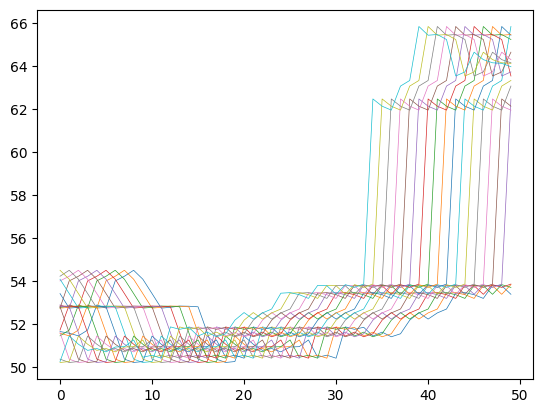

In [124]:
for k in range(sequenced_data.shape[0]):
    if k < 20:
        plt.plot(sequenced_data[k, :, 0], linewidth=0.5)
plt.show()


In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Features: all columns; Targets: first column (feature 0)
        x = self.data[idx, :-1, :]
        y = self.data[idx, -1, 0]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

class EarlyStopping:
    def __init__(self, patience=10, verbose=True, min_delta=1e-4, save_path="best_model.pth"):
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
                # New best loss found, save the model
                self.best_loss = val_loss
                self.counter = 0
                torch.save(model.state_dict(), self.save_path)
                if self.verbose:
                    print(f"Validation loss improved. Model saved to {self.save_path}")
            else:
                # No improvement, increment counter
                self.counter += 1
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
                    print("Early stopping triggered.")

train_data, test_data = train_test_split(sequenced_data, test_size=0.2, random_state=42, shuffle=False)
train_data = np.array(train_data)
test_data = np.array(test_data)

num_features = train_data.shape[2]  # Number of features
scalers = [StandardScaler() for _ in range(num_features)]

# Step 2: Fit the scalers on training data (feature-wise)
train_data_scaled = np.zeros_like(train_data)
test_data_scaled = np.zeros_like(test_data)

for feature_idx in range(num_features):
    # Extract the feature across all timesteps and samples
    train_feature = train_data[:, :, feature_idx].reshape(-1, 1)  # Shape: (num_samples * seq_len, 1)
    test_feature = test_data[:, :, feature_idx].reshape(-1, 1)
    
    # Fit scaler on the training feature
    scalers[feature_idx].fit(train_feature)
    
    # Transform training and test features
    train_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(train_feature).reshape(train_data.shape[0], -1)
    test_data_scaled[:, :, feature_idx] = scalers[feature_idx].transform(test_feature).reshape(test_data.shape[0], -1)

train_data = train_data_scaled
test_data = test_data_scaled

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_dim = train_data.shape[2]
hidden_dim = 256
num_layers = 4
output_dim = 1

learning_rate = 0.01
dropout = 0.2
weight_decay = 1e-4

num_epochs = 256

model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
early_stopping = EarlyStopping(patience=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
steps_per_epoch = len(train_loader)  # Total number of batches in one epoch
scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Step the scheduler
        scheduler.step()
        
        train_loss += loss.item()
    
    # Testing loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            test_outputs = model(x_test)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.8f}, "
          f"Test Loss: {test_loss/len(test_loader):.8f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    early_stopping(test_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

Epoch [1/256], Train Loss: 0.16617651, Test Loss: 0.00336282, LR: 0.000404
Validation loss improved. Model saved to best_model.pth
Epoch [2/256], Train Loss: 0.01048024, Test Loss: 0.00129115, LR: 0.000416
Validation loss improved. Model saved to best_model.pth
Epoch [3/256], Train Loss: 0.00863156, Test Loss: 0.00286095, LR: 0.000436
EarlyStopping counter: 1 out of 32
Epoch [4/256], Train Loss: 0.00814861, Test Loss: 0.00126009, LR: 0.000464
Validation loss improved. Model saved to best_model.pth
Epoch [5/256], Train Loss: 0.00737281, Test Loss: 0.00192751, LR: 0.000500
EarlyStopping counter: 1 out of 32
Epoch [6/256], Train Loss: 0.00614015, Test Loss: 0.00097444, LR: 0.000544
Validation loss improved. Model saved to best_model.pth
Epoch [7/256], Train Loss: 0.00600132, Test Loss: 0.00161335, LR: 0.000595
EarlyStopping counter: 1 out of 32
Epoch [8/256], Train Loss: 0.00556292, Test Loss: 0.00263090, LR: 0.000655
EarlyStopping counter: 2 out of 32
Epoch [9/256], Train Loss: 0.0058647

In [126]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
model.load_state_dict(torch.load('best_model.pth'))

/var/folders/pg/mh4np6_d0qs9cxq5clx1wbbw0000gn/T/ipykernel_29098/359333540.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.p

<All keys matched successfully>

Test Loss: 0.03171324
R² Coefficient on Test Set: 0.9819


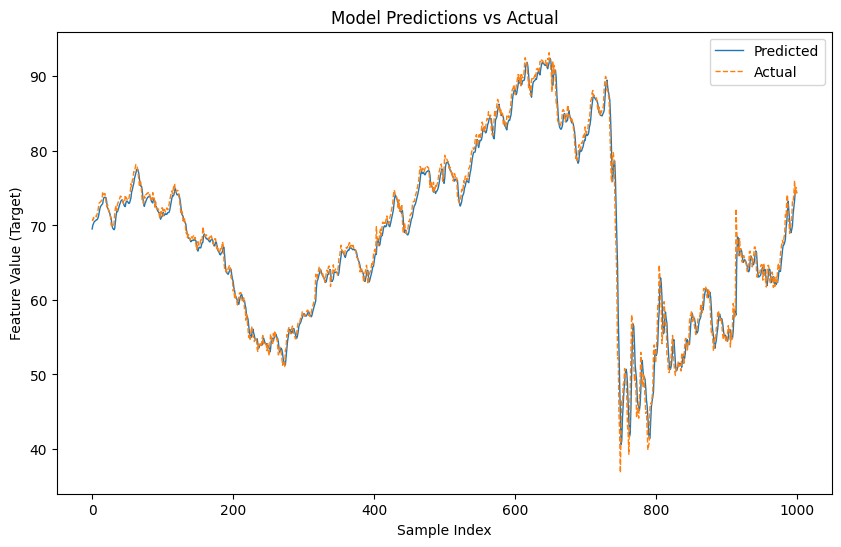

In [127]:
from sklearn.metrics import r2_score

def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    targets = []
    test_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            # Move data to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Model inference
            outputs = model(x_batch)
            
            # Detach and move to CPU
            preds = outputs.squeeze().cpu().numpy()  # Shape: (batch_size,)
            true_values = y_batch.cpu().numpy()      # Shape: (batch_size,)
            loss = criterion(test_outputs.squeeze(), y_test)
            test_loss += loss.item()
            # Collect predictions and targets
            predictions.extend(preds)
            targets.extend(true_values)
    print(f"Test Loss: {test_loss/len(test_loader):.8f}")
    # Reshape to 2D arrays (scaler expects 2D inputs)
    predictions = np.array(predictions).reshape(-1, 1)
    targets = np.array(targets).reshape(-1, 1)

    scaler = scalers[0]
    # Apply inverse transform
    predictions = scaler.inverse_transform(predictions)
    targets = scaler.inverse_transform(targets)
    return predictions.flatten(), targets.flatten()

# Evaluate on test set
predictions, targets = evaluate_model(model, test_loader)

predictions, targets = predictions[:1000], targets[:1000]
# Compute R² coefficient
r2 = r2_score(targets, predictions)
print(f"R² Coefficient on Test Set: {r2:.4f}")

# Plot Predictions vs Ground Truth
plt.figure(figsize=(10, 6))
plt.plot(predictions, label="Predicted", linestyle="-", linewidth=1)
plt.plot(targets, label="Actual", linestyle="--", linewidth=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value (Target)")
plt.legend()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/remibreton/miniconda3/envs/my_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 24%|██▍       | 242/1000 [00:08<00:26, 28.46it/s]/Users/remibreton/miniconda3/envs/my_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [00:34<00:00, 28.85it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.18E-03


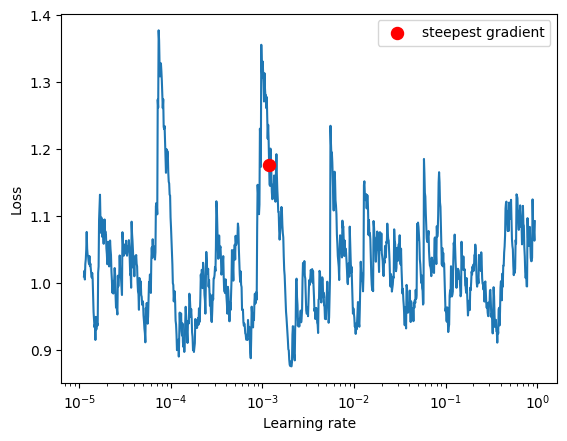

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.001180516528568805)

In [64]:
from torch_lr_finder import LRFinder

model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Start with a small LR
criterion = nn.MSELoss()

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=1, num_iter=1000)  # Test LRs between 1e-7 and 1
lr_finder.plot()

# Feeding Companies prices + sentiment as inputs

----> Big Drawback = Dimensionality curse : not enough data and the LSTM doesn't train properly

## Preprocessing data

In [91]:
def dates_filtering(news, prices):
    # Ensure 'date' columns are in datetime format
    news['date'] = pd.to_datetime(news['date'])
    prices['date'] = pd.to_datetime(prices['date'])

    # Find the intersection of dates
    common_dates = set(news['date']).intersection(set(prices['date']))

    # Filter rows from both DataFrames where the date is in the common_dates
    filtered_news = news[news['date'].isin(common_dates)]
    filtered_prices = prices[prices['date'].isin(common_dates)]
    return filtered_news, filtered_prices

In [92]:
news, df = dates_filtering(news, prices)

In [93]:
def mixing_data(news, df, include_news=True, train_size=0.8, random_state=None):
    """
    Combine company data with sentiment data, process features, and split into train-test sets.

    Args:
        news (pd.DataFrame): News sentiment data with 'date', 'negative', 'positive', and 'neutral' columns.
        df (pd.DataFrame): Company stock data with 'Company', 'High', and 'date' columns.
        include_news (bool): Whether to include sentiment data.
        train_size (float): Proportion of data to use for training.
        random_state (int, optional): Random state for reproducibility.

    Returns:
        tuple: (train_data, test_data), where each is a NumPy array.
    """
    data = []
    companies = df['Company'].drop_duplicates().values
    features = 50  # Number of companies to process
    
    # Process company data
    for company in tqdm(companies[:features], desc="Processing company data"):
        company_data = df[df['Company'] == company]['High'].values
        company_data = (company_data[1:] - company_data[:-1]) / company_data[:-1]  # Compute returns
        data.append(company_data)

    data = np.array(data)  # Shape: (features, timesteps)
    
    # Include sentiment data if specified
    if include_news:
        sentiment_data = []
        dates = df['date'].drop_duplicates().values

        for date in tqdm(dates[1:], desc="Processing sentiment data"):
            sentiment_data_day = news[news['date'] == date][['negative', 'positive', 'neutral']].values.flatten()
            sentiment_data.append(sentiment_data_day)

        sentiment_data = np.array(sentiment_data)  # Shape: (timesteps, sentiment_features)

        # Check for timestep mismatch
        if data.shape[1] != sentiment_data.shape[0]:
            raise ValueError(f"Mismatch in timesteps: company_data ({data.shape[1]}) vs sentiment_data ({sentiment_data.shape[0]})")

        sentiment_data = sentiment_data.T  # Shape: (sentiment_features, timesteps)
        
        # Combine company data with sentiment data
        data = np.concatenate((data, sentiment_data), axis=0).T  # Shape: (timesteps, features + sentiment_features)

    # Train-test split
    train_data, test_data = train_test_split(
        data,
        train_size=train_size,
        shuffle=False,  # Maintain temporal order
        random_state=random_state
    )

    return train_data, test_data

In [ ]:
train_data, test_data = mixing_data(news, df, include_news=True)

In [95]:
class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, data, target_indices, sequence_length):
        self.data = data # Shape must be : (data_length, num_features)
        self.target_indices = target_indices
        self.sequence_length = sequence_length
    
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.sequence_length, :]
        y = self.data[idx+self.sequence_length, self.target_indices]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [96]:
def load_multivariate_data(train_data, test_data, target_index, sequence_length):
    # Scale each feature independently
    # MinMaxScaling produces constant outputs because there are too small values
    scalers = [StandardScaler() for _ in range(train_data.shape[1])]
    train_scaled = np.zeros_like(train_data)
    test_scaled = np.zeros_like(test_data)
    for i, scaler in enumerate(scalers):
        train_scaled[:, i] = scaler.fit_transform(train_data[:, i].reshape(-1, 1)).flatten()
        test_scaled[:, i] = scaler.transform(test_data[:, i].reshape(-1, 1)).flatten()
    train_dataset = MultivariateTimeSeriesDataset(train_scaled, target_index, sequence_length)
    test_dataset = MultivariateTimeSeriesDataset(test_scaled, target_index, sequence_length)
    
    return train_dataset, test_dataset, scalers

In [97]:
sequence_length = 30
target_indices = [k for k in range(50)]

train_dataset, test_dataset, scalers = load_multivariate_data(train_data, test_data, target_indices, sequence_length)

In [ ]:
print("Train data shape", train_dataset.data.shape)
print("Validation data shape", test_dataset.data.shape)

In [99]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model

### LSTM

In [100]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, intermediate_size=256, dropout=0.2):
        super(LSTM, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(intermediate_size, intermediate_size)
        self.tanh = nn.Tanh()
        self.dropout2 = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(intermediate_size, output_size)
    
    def forward(self, x, h0=None, c0=None):
        # Use hidden states only if provided
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
            c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Take the last time step's output
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        # Fully connected layer to produce the final output
        out = self.fc1(out)
        out = self.sigmoid(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.dropout2(out)
        out = self.fc3(out) # Shape: (batch_size, output_size)
        return out

### Early Stopping

In [101]:
class EarlyStopping:
    """Early stopping to terminate training when validation loss stops improving."""
    def __init__(self, patience=5, delta=0, verbose=False, path="checkpoint.pth"):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            verbose (bool): If True, prints a message for each validation loss improvement.
            path (str): Path to save the best model checkpoint.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float("inf")  # Initialize minimum validation loss

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Model Definition

In [ ]:
input_size = train_data.shape[1]
output_size = len(target_indices)

# Hyperparameters for the structure of the model
hidden_size = 64
num_layers = 3
dropout = 0.0

# Training hyperparameters
learning_rate = 0.01
epochs = 1000

# Initialize the LSTM model
lstm = LSTM(input_size, hidden_size, output_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=100, verbose=True)

## Training Loop

In [103]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, early_stopping=None, clip_value=1.0):
    """
    Train the model with detailed logging for loss variations and learning rate changes.

    Args:
        model: PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimizer.
        scheduler: Learning rate scheduler.
        epochs: Number of training epochs.
        early_stopping: EarlyStopping object for patience-based stopping.
        clip_value: Gradient clipping value.
    """
    prev_val_loss = None  # Track previous validation loss
    prev_lr = optimizer.param_groups[0]['lr']  # Track previous learning rate
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = criterion(y_pred, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item() * batch_x.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                y_pred = model(batch_x)
                loss = criterion(y_pred, batch_y)
                val_loss += loss.item() * batch_x.size(0)

        val_loss /= len(val_loader.dataset)

        # Log the losses
        loss_change = f"({val_loss - prev_val_loss:.6f})" if prev_val_loss is not None else ""
        print(f"\nEpoch {epoch+1}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f} {loss_change}")
        prev_val_loss = val_loss

        # Scheduler step and learning rate logging
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        if current_lr < prev_lr:  # Log only if LR was updated
            print(f"Learning Rate decreased ({prev_lr:.6e} --> {current_lr:.6e}).")
        prev_lr = current_lr  # Update previous learning rate

        # Early stopping (if provided)
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f"\nEarly stopping triggered. Final validation loss: {val_loss:.6f}")
                break

In [ ]:
train_model(
    model=lstm, 
    train_loader=train_loader, 
    val_loader=test_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=epochs, 
    early_stopping=early_stopping,
    scheduler=scheduler
    )

## Evaluation

In [86]:
def get_prediction():
    lstm.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = lstm(batch_x)
            y_true.append(batch_y.numpy())
            y_pred.append(outputs.numpy())
    # Concatenate all batches
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    # Inverse transform predictions and ground truth for the target features
    y_true_rescaled, y_pred_rescaled = [], []
    for i, target_index in enumerate(target_indices):
        scaler = scalers[target_index]
        y_true_rescaled.append(scaler.inverse_transform(y_true[:, i].reshape(-1, 1)).flatten())
        y_pred_rescaled.append(scaler.inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten())

    y_true_rescaled = np.stack(y_true_rescaled, axis=1)
    y_pred_rescaled = np.stack(y_pred_rescaled, axis=1)
    return y_true_rescaled, y_pred_rescaled

In [87]:
def evaluate_model(model, test_loader, scalers, target_indices):
    y_true_rescaled, y_pred_rescaled = get_prediction()
    # Compute R2 scores for each feature
    r2_scores = [r2_score(y_true_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(len(target_indices))]
    return r2_scores

In [ ]:
r2_scores = evaluate_model(
    model=lstm,
    test_loader=test_loader,
    scalers=scalers,
    target_indices=target_indices
)

print(f'Average r2 score: {np.mean(r2_scores)}')

In [ ]:
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
plt.bar(range(len(r2_scores)), r2_scores, width=0.5)
plt.xlabel("Index", fontsize=12)
plt.ylabel("R2 Score", fontsize=12)
plt.title("Bar Plot of R2 Scores", fontsize=14)
plt.show()

In [303]:
def plot_predictions(num_samples=10):
    y_true, y_pred = get_prediction()
    for i in range(50, 50 + num_samples):
        # Compute R2 score
        r2 = r2_score(y_true[:, i], y_pred[:, i])

        # Plot true and predicted values
        plt.figure(figsize=(10, 4))
        plt.plot(y_true[:, i], label='True', linewidth=0.5)
        plt.plot(y_pred[:, i], label='Predicted', linewidth=0.8)
        
        # Add R2 score to the legend
        plt.title(f"Asset {i}")
        plt.legend([f"True", f"Predicted (r2: {r2:.3f})"])
        plt.show()


In [ ]:
plot_predictions()

# Application with trading strategies ?